In [3]:
# --- One-time setup 
import sys, subprocess

def pip_install(pkg):
    try:
        __import__(pkg.split("[")[0].replace("-", "_"))
    except ImportError:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

# (pip install)
pip_install("sentence-transformers")
pip_install("fuzzywuzzy[speedup]")
pip_install("groq")        
pip_install("openai")      


Installing sentence-transformers ...
Installing fuzzywuzzy[speedup] ...
Installing groq ...
Installing openai ...


In [41]:

# ===============================
# Core
# ===============================
!pip install umap-learn
import os, re, warnings
import numpy as np
!pip install pandas
import pandas as pd
import joblib
from tqdm import tqdm
warnings.filterwarnings("ignore")

# ===============================
# NLP / Vectorization
# ===============================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# embedding baseline (semantic retrieval)
from sentence_transformers import SentenceTransformer

# fuzzy matching utility 
from fuzzywuzzy import fuzz

# ===============================
# Modeling (classification scope)
# ===============================
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# ===============================
# Metrics
# ===============================
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)

# ===============================
# Visualization
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality-reduction for visuals 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap  # This will now work after installing umap-learn

# ===============================
# LLM Clients (for narrative layer)
# ===============================
from groq import Groq        
from openai import OpenAI

In [7]:
!python -m spacy download en_core_web_sm
!pip install python-Levenshtein


C:\Users\John\anaconda3\python.exe: No module named spacy


In [43]:



import os
df = pd.read_csv(os.path.join(os.path.expanduser("~"), "Downloads/cleaned_work_orders.csv"))

df = df.dropna(how='all')

# Drop noise in Data
df = df[~df['Text'].str.contains("completed", case=False, na=False)]
df = df[~df['Text'].str.contains("complete", case=False, na=False)]
df = df[~df['Text'].str.contains("mike", case=False, na=False)]
df = df[~df['Text'].str.contains("mike's", case=False, na=False)]
df = df[~df['Text'].str.contains("odd", case=False, na=False)]

df = df.dropna(subset=['Description', 'Text']).drop_duplicates()

# Keep only rows where WO No. is numeric
df = df[df['WO No.'].astype(str).str.match(r'^\d+$')]

# Strip spaces and standardize text fields
df['WO No.'] = df['WO No.'].astype(str).str.strip()
df['Description'] = df['Description'].astype(str).str.strip()
df['Text'] = df['Text'].astype(str).str.strip()

# Clean Description
df['Description_cleaned'] = (
    df['Description']
    .fillna("")
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    .str.replace(r'\d+', '', regex=True)      # Remove digits
    .str.strip()
)

# Clean Technician Text Notes
df['Text_cleaned'] = (
    df['Text']
    .fillna("")
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.replace(r'\d+', '', regex=True)
    .str.strip()
)

# Keep rows where both sides exist and are not trivial
df = df[['Description_cleaned', 'Text_cleaned']].dropna()
df = df[df['Description_cleaned'].str.strip() != ""]
df = df[df['Text_cleaned'].str.strip() != ""]

# Filter out rows with completely blank descriptions and notes
df = df[~((df['Description_cleaned'].str.strip() == "") & (df['Text_cleaned'].str.strip() == ""))]

# Ensure valid technician notes
df = df[df['Text_cleaned'].notna() & (df['Text_cleaned'].str.strip() != "") & (df['Text_cleaned'].str.lower().str.strip() != "nan")]

# Show data sample for verification
display(df[['Description_cleaned', 'Text_cleaned']].head())

,Description_cleaned,Text_cleaned
9,cushion,checking on a new controller ordered controller
11,take out section of conveyor on vertical oven ...,took out about ft of chain
12,stop time,press was in a wierd position causing the disc...
13,remove gas meter from solder pour machine,removed gas meter and installed replacement pipe
23,check bearings making noise,problem stopped


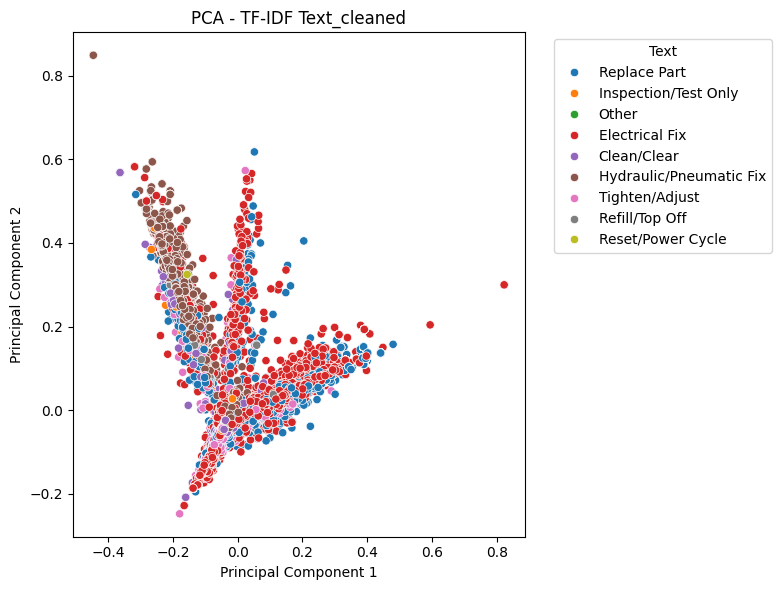

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer # Ensure TfidfVectorizer is imported if not globally available

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(df['Text_cleaned'].fillna(''))
y = df['Response_Label']

# Use sklearn's PCA explicitly
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10')
plt.title("PCA - TF-IDF Text_cleaned")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Text', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **4. Split Train & Test**

In [46]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize 
vectorizer = TfidfVectorizer(stop_words='english', max_features=8000, min_df=3)
X = vectorizer.fit_transform(df['Description_cleaned'].astype(str))
y = df['Response_Label'].astype(str)

# Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# Dimensionality reduction 
svd = TruncatedSVD(n_components=150, random_state=42)
X_dense = svd.fit_transform(X)  

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# SMOTE on dense features
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original class counts:", Counter(y))
print("Train (encoded) before:", Counter(y_train))
print("Train (encoded) after :", Counter(y_train_res))


Original class counts: Counter({'Electrical Fix': 14487, 'Other': 9822, 'Replace Part': 8775, 'Tighten/Adjust': 5862, 'Hydraulic/Pneumatic Fix': 3718, 'Inspection/Test Only': 3388, 'Clean/Clear': 3170, 'Reset/Power Cycle': 226, 'Refill/Top Off': 211})
Train (encoded) before: Counter({np.int64(1): 11589, np.int64(4): 7858, np.int64(6): 7020, np.int64(8): 4690, np.int64(2): 2974, np.int64(3): 2710, np.int64(0): 2536, np.int64(7): 181, np.int64(5): 169})
Train (encoded) after : Counter({np.int64(4): 11589, np.int64(0): 11589, np.int64(8): 11589, np.int64(1): 11589, np.int64(3): 11589, np.int64(6): 11589, np.int64(2): 11589, np.int64(5): 11589, np.int64(7): 11589})


# Training Prep

In [47]:
# Convert to numpy for sklearn
X_embed_np = np.array(X_embed)

# Prepare target labels (supervised)
y = df['Response_Label'].reset_index(drop=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embed_np, y, test_size=0.2, stratify=y, random_state=42)

# Train classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# 8. Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


                         precision    recall  f1-score   support

            Clean/Clear       0.34      0.04      0.07       634
         Electrical Fix       0.37      0.72      0.49      2898
Hydraulic/Pneumatic Fix       0.31      0.06      0.11       744
   Inspection/Test Only       0.18      0.01      0.02       678
                  Other       0.44      0.45      0.44      1964
         Refill/Top Off       0.00      0.00      0.00        42
           Replace Part       0.34      0.23      0.27      1755
      Reset/Power Cycle       0.00      0.00      0.00        45
         Tighten/Adjust       0.32      0.25      0.28      1172

               accuracy                           0.38      9932
              macro avg       0.25      0.20      0.19      9932
           weighted avg       0.35      0.38      0.33      9932

